# Data Augmentation (Veri Büyütme)

Bir makine öğrenimi modelinin performansını iyileştirmenin en iyi yolu, onu daha fazla veri üzerinde eğitmektir. Model ne kadar çok örnek öğrenirse, görüntülerdeki hangi farklılıkların önemli hangilerinin önemsiz olduğunu o kadar iyi anlayabilir. Daha fazla veri, modelin daha iyi genellemesine yardımcı olur.<br><br>

Daha fazla veri elde etmenin kolay bir yolu, zaten sahip olduğunuz verileri kullanmaktır. Veri kümemizdeki görüntüleri sınıfı koruyabilecek şekilde dönüştürebilirsek, sınıflandırıcımıza bu tür dönüşümleri yok saymasını öğretebiliriz. Örneğin bir fotoğrafta bir arabanın sağa veya sola bakması onun kamyon değil araba olduğu gerçeğini değiştirmez.Bu nedenle, eğitim verilerimizi ters çevrilmiş görüntülerle zenginleştirirsek, sınıflandırıcımız "sol veya sağ" ' ın göz ardı edilecek bir fark olduğunu öğrenecektir.<br><br>

Veri artırmanın arkasındaki bütün fikir budur: gerçek verilere makul ölçüde benzeyen bazı ekstra sahte veriler ekleyin ve sınıflandırıcınız gelişecektir.

Veri kümesini genişletirken kullanılan bazı dönüşümler: renk, kontrast ayarlama, görüntüyü çarpıtma ve birlikte uygulanan birçok şey...

Veri büyütme online olarak gerçekleşir. Eğitim sırasında bir görüntü her kullanıldığında, yeni bir rastgele dönüşüm uygulanır. Bu şekilde her zaman daha önce gördüğünden biraz farklı bir şey görür. Eğitim verilerindeki bu ekstra varynas, modele yeni verilerde yardımcı olan şeydir.

Her dönüşüm belirli bir problemde faydalı olmayabilir.En önemlisi, hangi dönüşümleri kullanırsanız kullanın sınıfları karıştırmamalısınız. Örneğin bir rakam tanıyıcıyı eğitiyor olsaydınız, görüntüleri döndürmek '9' ve '6' ' ları karıştırırdı.

Keras verileriniz 2 şekilde artırmanıza olanak tanır. İlk yol, onu ImageDataGenerator gibi bir işlevle veri hattına dahil etmektir. İkinci yol ise, Keras'ın preprocessing layers (ön işleme katmanları) ' nı kullanarak onu model tanımına dahil etmektir. Birincil avantaj, görüntü dönüşümlerinin CPU yerine GPU'da heasaplanması ve potansiyel olarak eğitimi hızlandırmasıdır.

# Training with Data Augmentation (Veri Büyütme ile Eğitim)

In [21]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'datas/horse-or-human/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'datas/horse-or-human/validation',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


# Step 2: Define Model (Modeli Tanımla)

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.applications.vgg16 import VGG16
# Bunlar TF 2.2'de yeni özellikler
from tensorflow.keras.layers.experimental import preprocessing

# VGG16 yükleme
IMAGE = [128, 128]
pretrained_base = VGG16(input_shape=IMAGE + [3], weights='imagenet', include_top=False)

#pretrained_base = tf.keras.models.load_model(
#    '../input/cv-course-models/cv-course-models/vgg16-pretrained-base'
#)

pretrained_base.trainable = False

model = keras.Sequential([
    # Preprocessing
    preprocessing.RandomFlip('horizontal'), # flip left-to-right (soldan sağa döndür)
    preprocessing.RandomContrast(0.5), # contrast change by up to %50 (%50'ye varan kontrast değişikliği)
    
    # Base
    pretrained_base,
    
    # Head
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Step 3: Train and Evaluate (Eğit ve Değerlendir)

Eğitime başlayalım

In [13]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data = ds_valid,
    epochs=30,
    verbose=0
)

KeyboardInterrupt: 

In [ ]:
import pandas as pd

history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

# Explore Augmentation (Demo)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


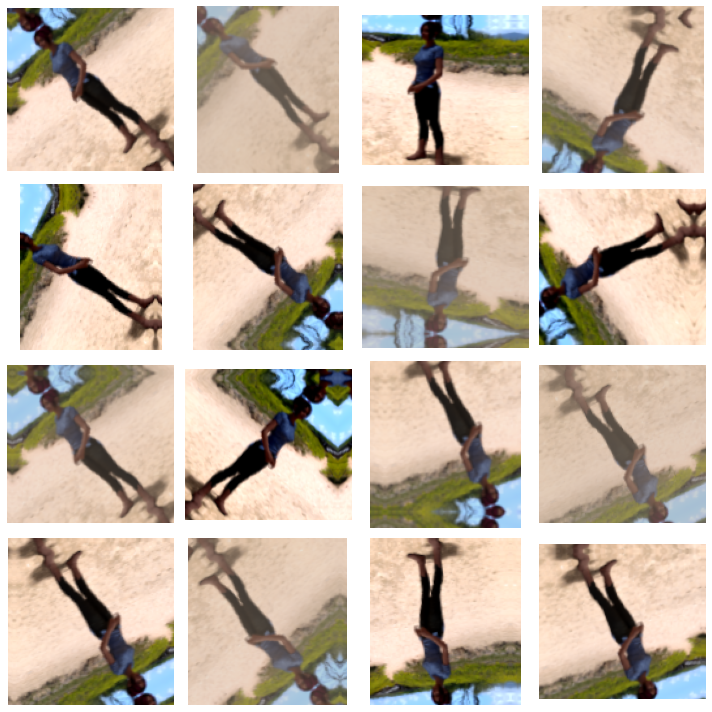

In [22]:
# her "factor" parametresi yüzdelik değişimi belirtir
augment = keras.Sequential([
    preprocessing.RandomContrast(factor=0.5),
    preprocessing.RandomFlip(mode='horizontal'), # soldan sağa
    preprocessing.RandomFlip(mode='vertical'), # yukarıdan aşağıya
    preprocessing.RandomWidth(factor=0.15), # horizontal(yatay) uzatma
    preprocessing.RandomRotation(factor=0.20), # rotasyon (açı)
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1), # output yüksekliğini %10 aşağı veya yukarı kaydırır
])

ex = next(iter(ds_train.unbatch().map(lambda x, y:x).batch(1)))

plt.figure(figsize=(10, 10))
for i in range(16):
    image = augment(ex, training=True)
    plt.subplot(4, 4, i+1)
    plt.imshow(tf.squeeze(image))
    plt.axis('off')
plt.show()

# Add Preprocessing Layers

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),
    
    # Data Augmentation
    preprocessing.RandomContrast(factor=0.10),
    preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomRotation(factor=0.10),
    
    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    # Head
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

# Modelimiz eğitelim

In [16]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
)

# Plot learning curves
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

Epoch 1/50
27/80 [=========>....................] - ETA: 3:26 - loss: 0.6828 - binary_accuracy: 0.5747

KeyboardInterrupt: 